In [6]:
import os
import json

# Define the filepaths
input_folder = "/media/alexmatthews/Alex_011/ZOOL412/rot_learning_cutdown"
output_folder = "/media/alexmatthews/Alex_011/ZOOL412/rot_learning_outputs"
output_file = os.path.join(output_folder, "rotational_data_processed.json")

# Initialize a dictionary to store the processed data
processed_data = {}

# Function to process a single file
def process_file(filepath, duration):
    with open(filepath, 'r') as file:
        lines = file.readlines()
    
    # Clean lines from newline characters and empty lines
    lines = [line.strip() for line in lines if line.strip()]
    
    # Extract metadata
    animal_id = None
    trial_number = None
    learning_odour = None
    odour_positions = {}

    for line in lines:
        if line.startswith("Animal ID:"):
            animal_id = int(line.split(":")[1].strip())
        elif line.startswith("Trial Number:"):
            trial_number = int(line.split(":")[1].strip())
        elif line.startswith("Learning Odour:"):
            learning_odour = line.split(":")[1].strip()
        elif "Position:" in line:
            parts = line.split(",")
            odour_name = parts[0].split(":")[1].strip()
            odour_position = float(parts[1].split(":")[1].strip().replace("°", ""))
            odour_positions[odour_name] = odour_position

    if animal_id is None or trial_number is None or learning_odour is None:
        raise ValueError(f"Missing metadata in file: {filepath}")

    learning_odour_angle = odour_positions[learning_odour]

    # Extract trajectory data
    trajectory_data_start = lines.index("Trajectory Data (Time, Angle)") + 1
    trajectory_data = []
    for line in lines[trajectory_data_start:]:
        if line.strip() and not line.startswith("----"):  # Skip empty lines and lines with dashes
            try:
                time, angle = map(float, line.split())
                trajectory_data.append((time, angle))
            except ValueError:
                continue
    
    # Find the first timestamp where the angle is within ±10 degrees of the learning odour angle for the specified duration
    start_time = None
    time_within_range = 0
    for time, angle in trajectory_data:
        if abs(angle - learning_odour_angle) <= 10:
            if start_time is None:
                start_time = time
            time_within_range += 1 / 50  # Each frame is 1/50th of a second
        else:
            start_time = None
            time_within_range = 0

        if time_within_range >= duration:
            break

    if time_within_range < duration:
        start_time = None  # If no valid start time is found

    return {
        "animal_id": animal_id,
        "trial_number": trial_number,
        "learning_odour": learning_odour,
        "start_time": start_time
    }

# Function to process all files in the input folder
def process_all_files(input_folder, output_file, duration):
    # Iterate over all files in the input folder
    for filename in os.listdir(input_folder):
        if filename.endswith(".txt"):
            filepath = os.path.join(input_folder, filename)
            try:
                data = process_file(filepath, duration)
                animal_id = data["animal_id"]
                trial_number = data["trial_number"]
                if animal_id not in processed_data:
                    processed_data[animal_id] = {}
                processed_data[animal_id][trial_number] = data
            except Exception as e:
                print(f"Error processing file {filepath}: {e}")

    # Save the processed data to a JSON file
    with open(output_file, 'w') as json_file:
        json.dump(processed_data, json_file, indent=4)

    print(f"Processed data saved to {output_file}")

# Example usage:
# Define the duration (in seconds) for the angle to be within ±10 degrees of the learning odour angle
user_defined_duration = 10  # Change this value as needed
process_all_files(input_folder, output_file, user_defined_duration)


Processed data saved to /media/alexmatthews/Alex_011/ZOOL412/rot_learning_outputs/rotational_data_processed.json


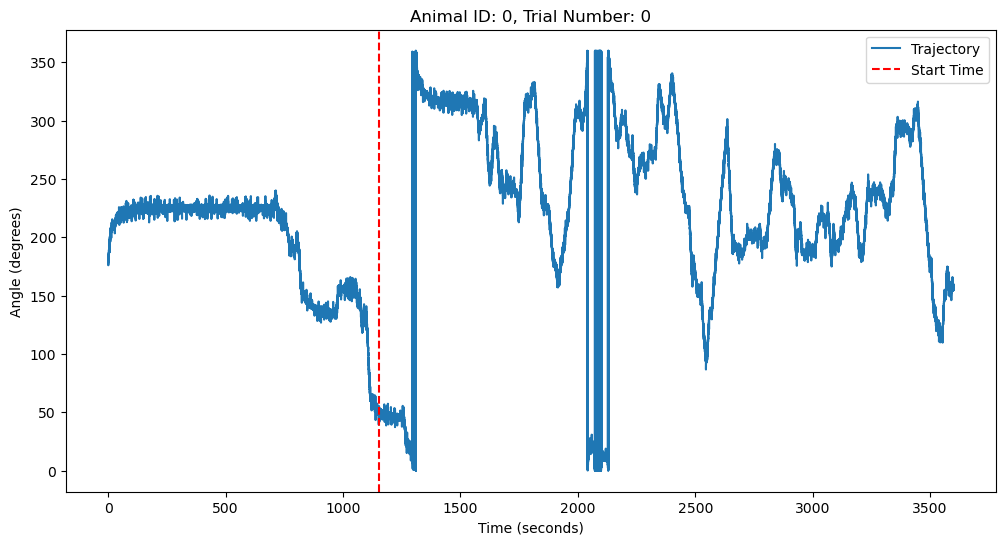

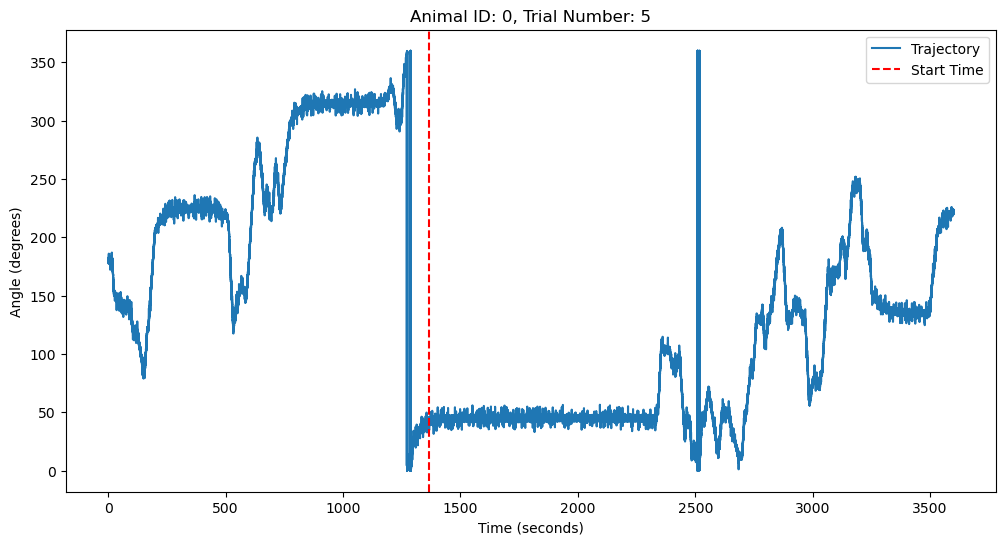

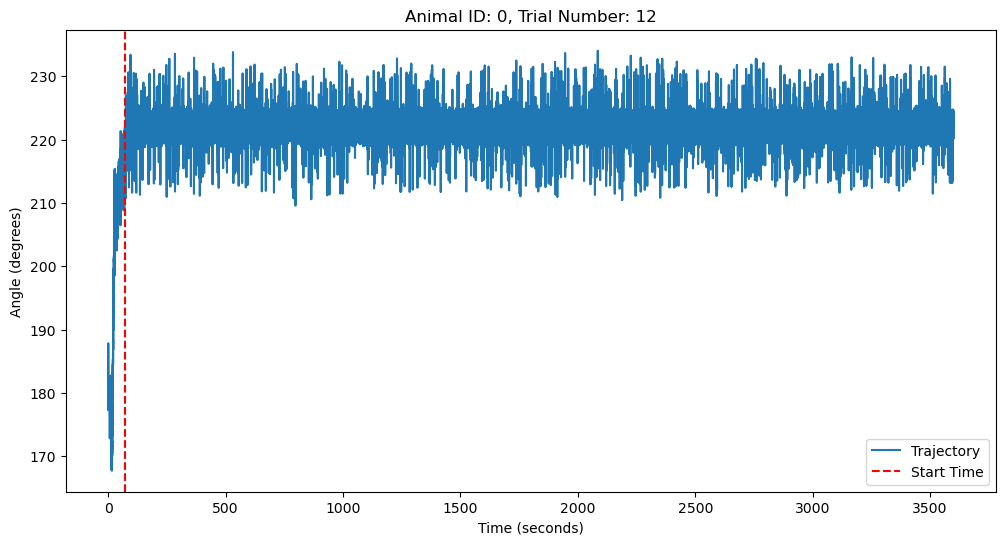

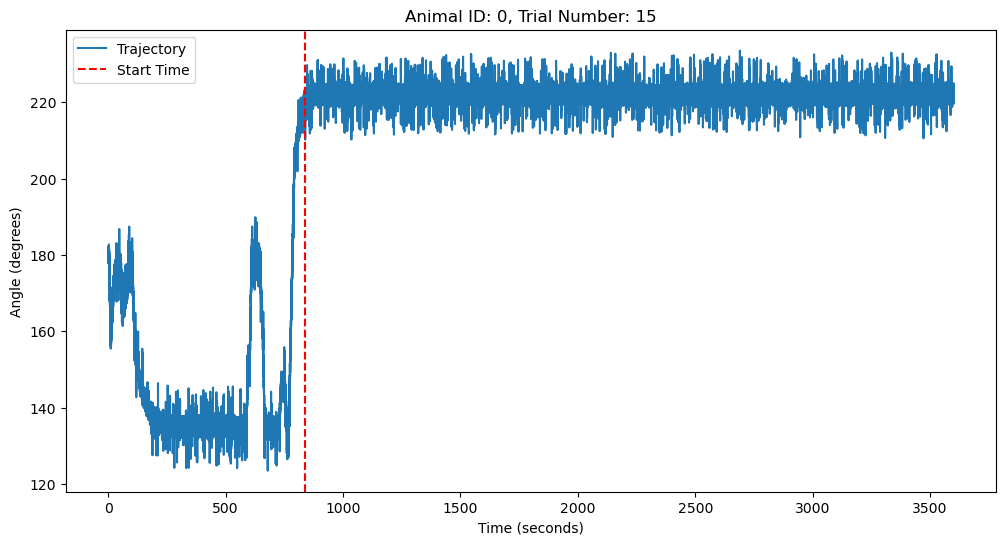

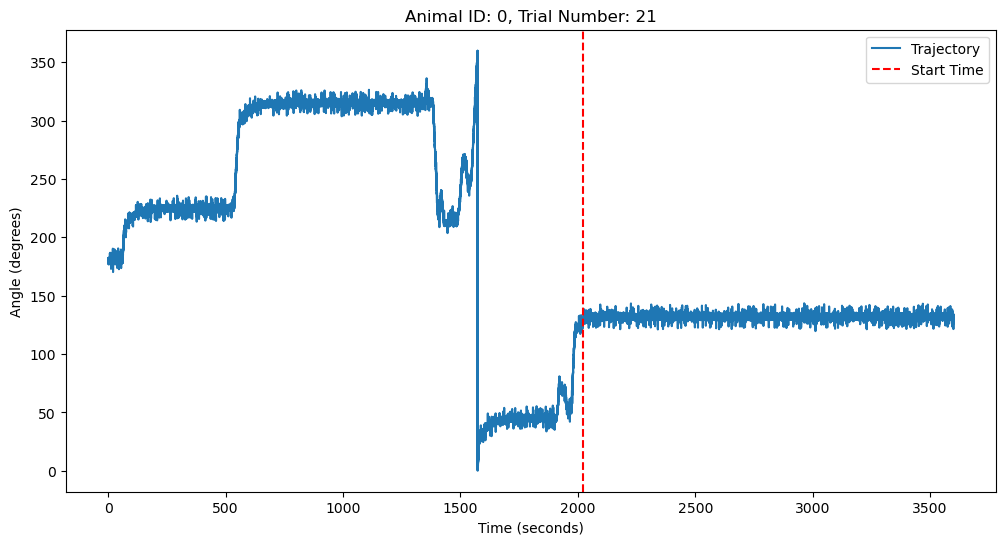

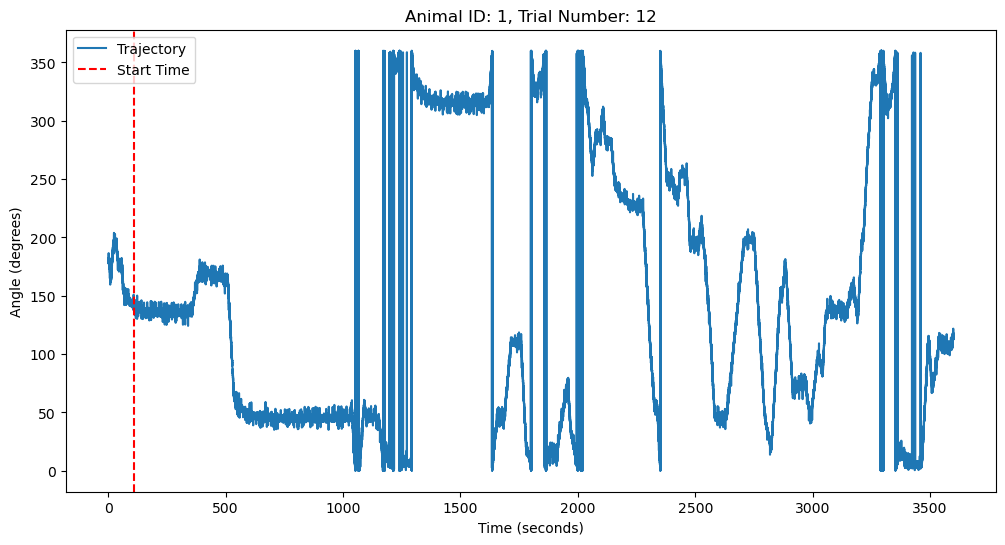

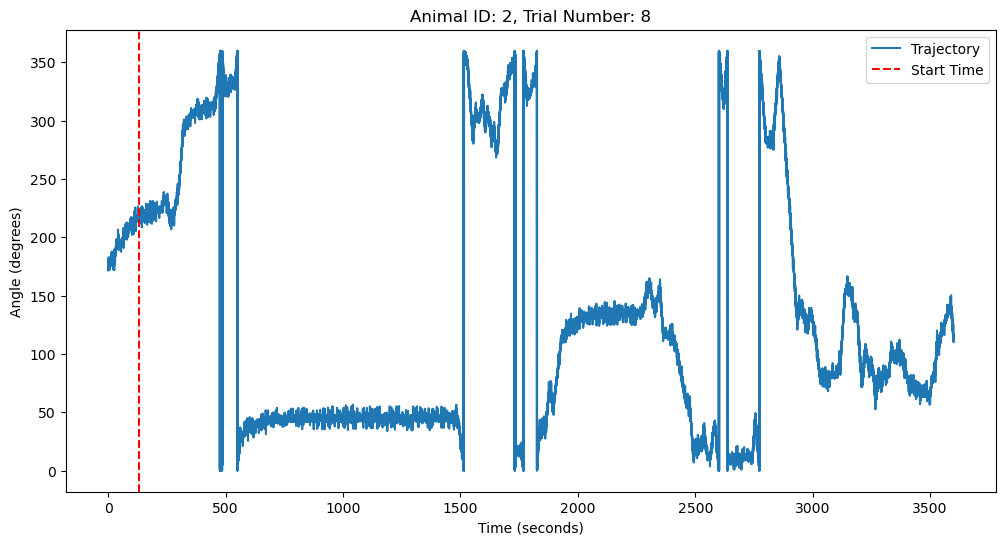

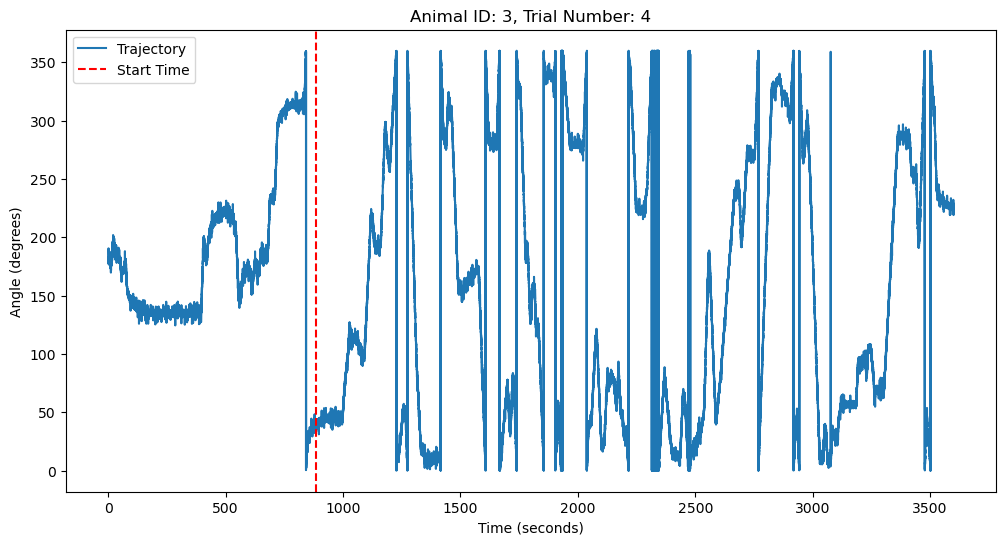

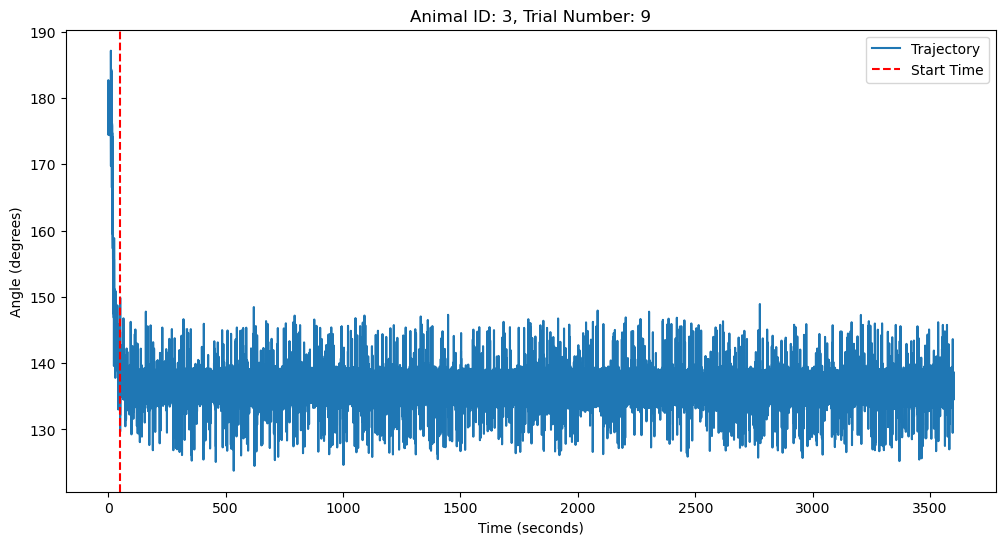

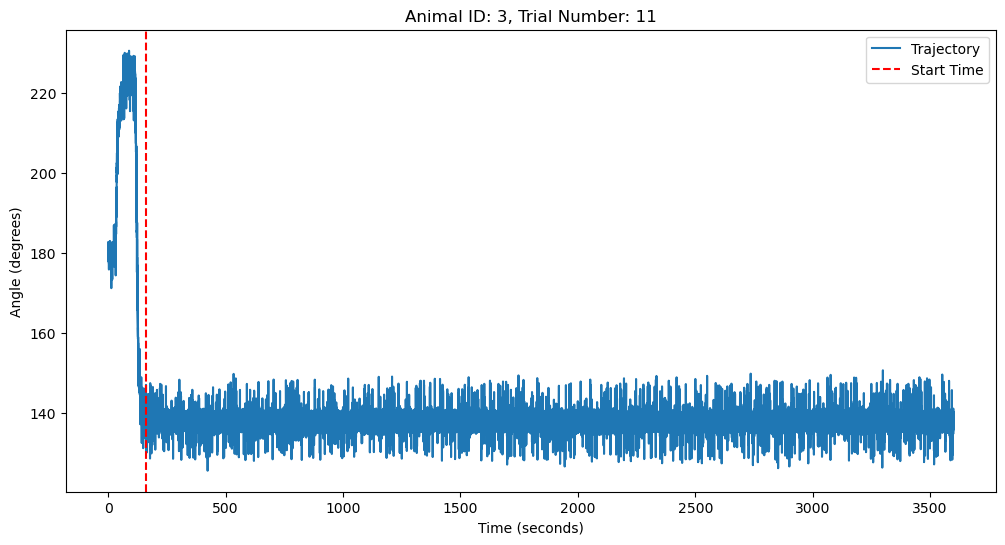

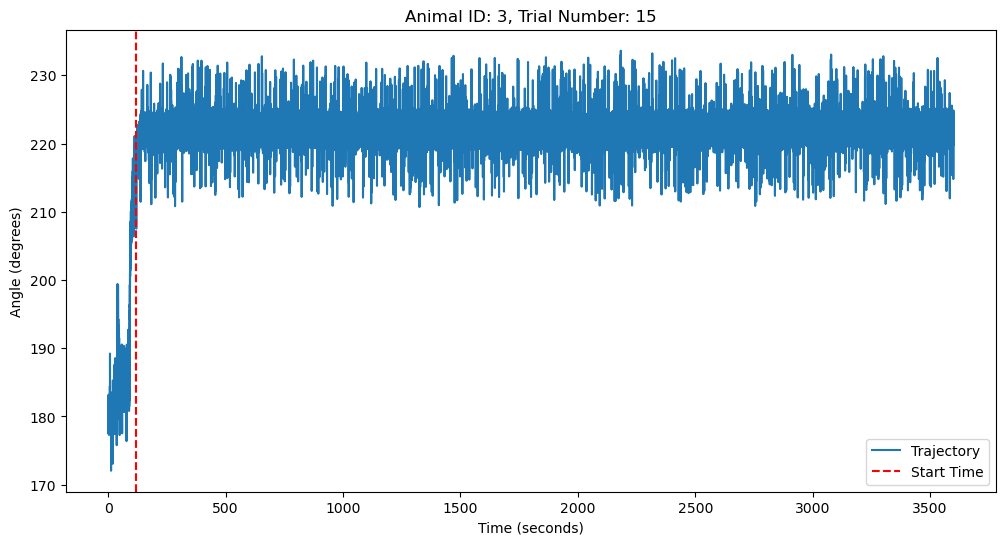

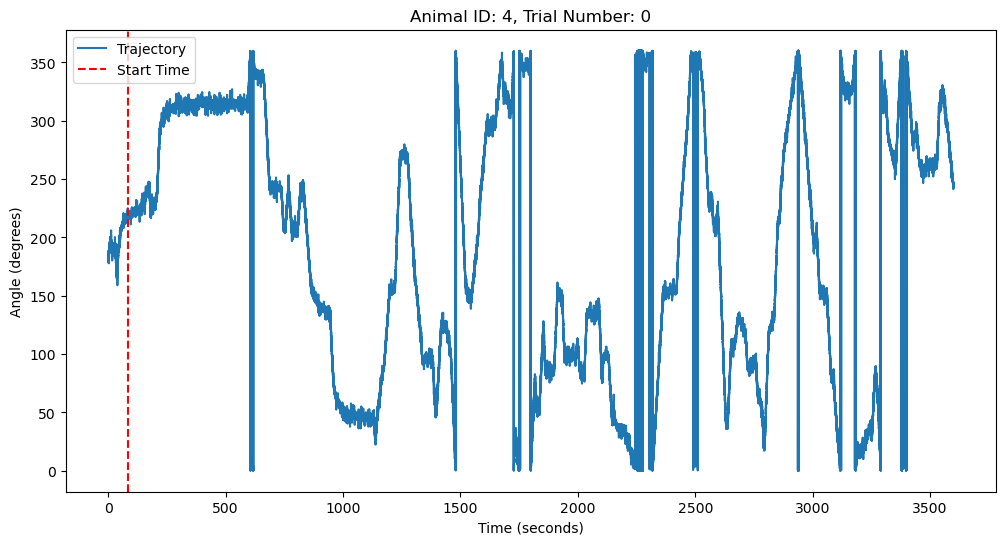

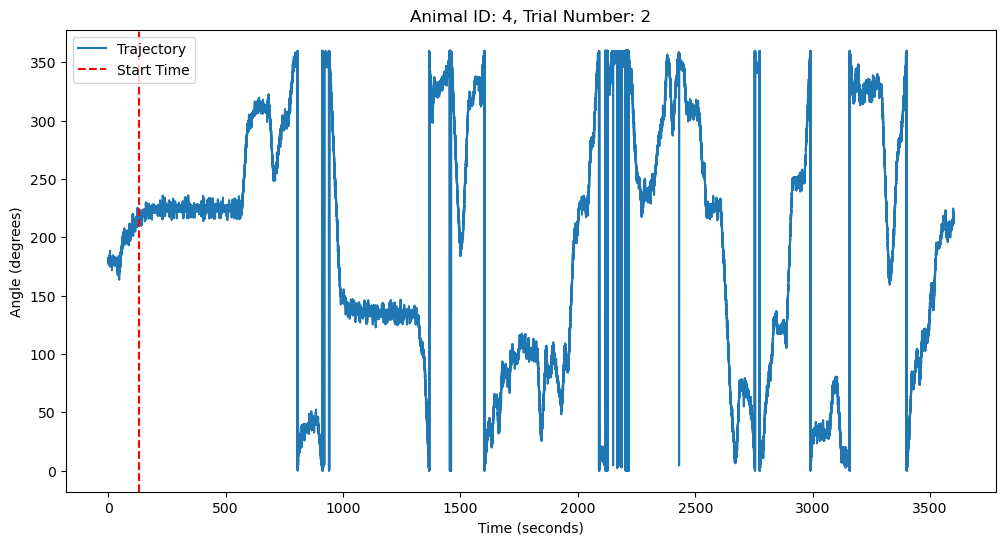

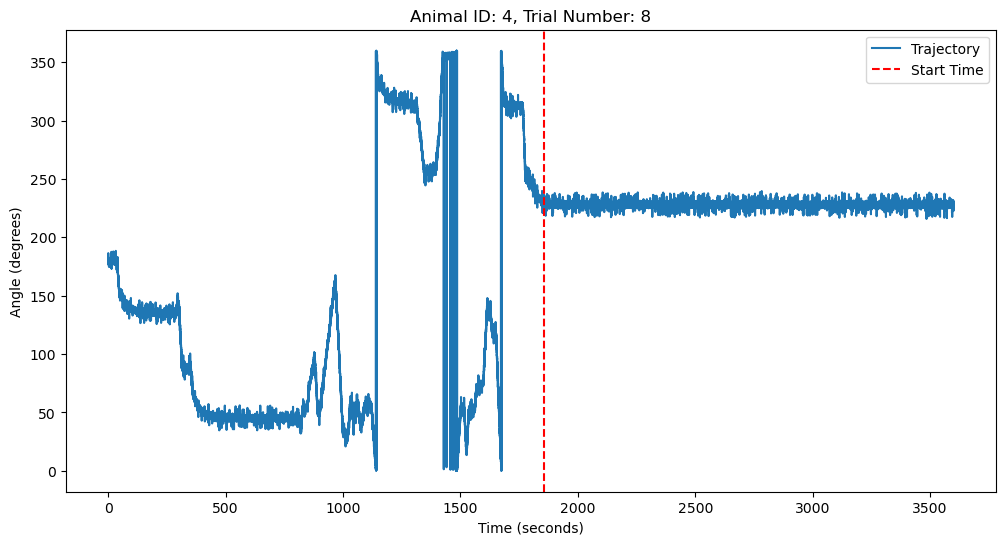

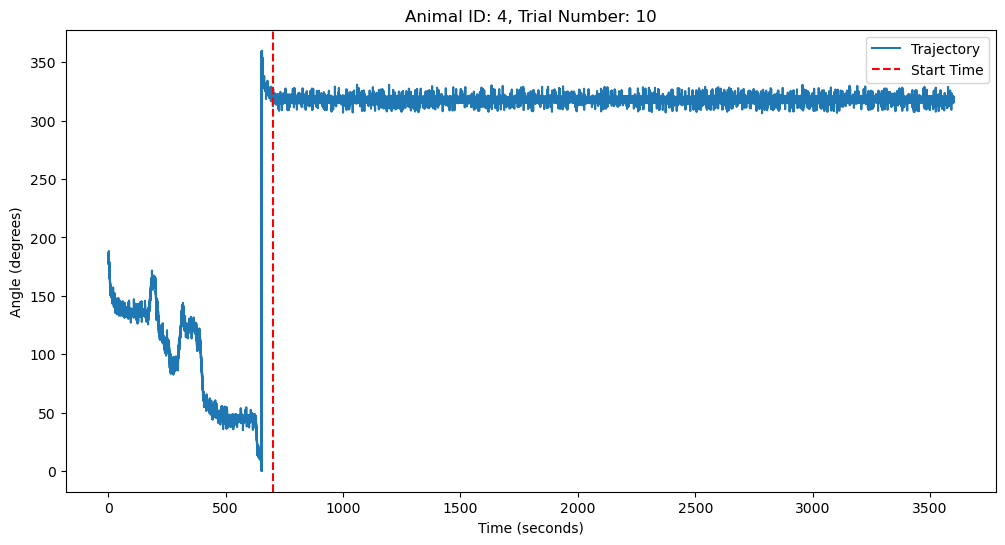

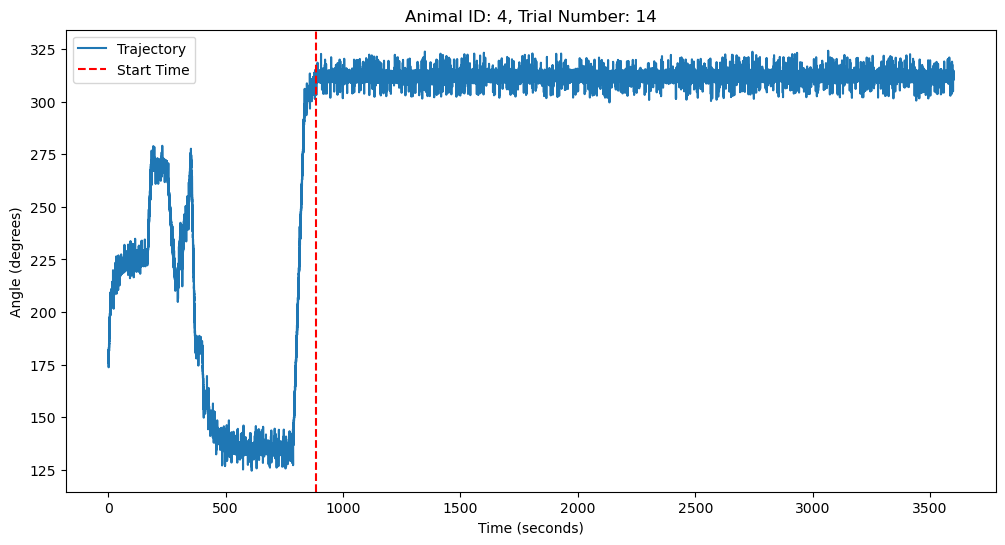

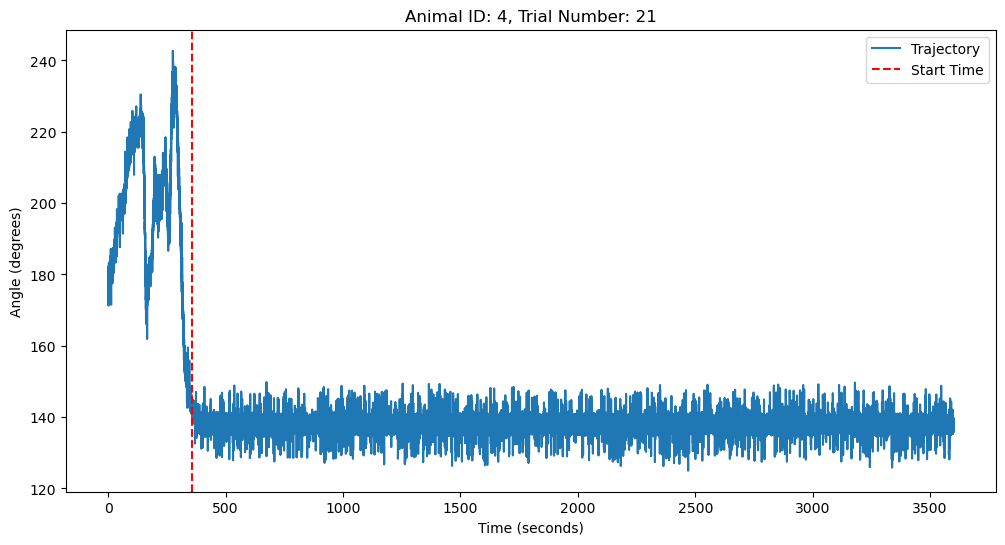

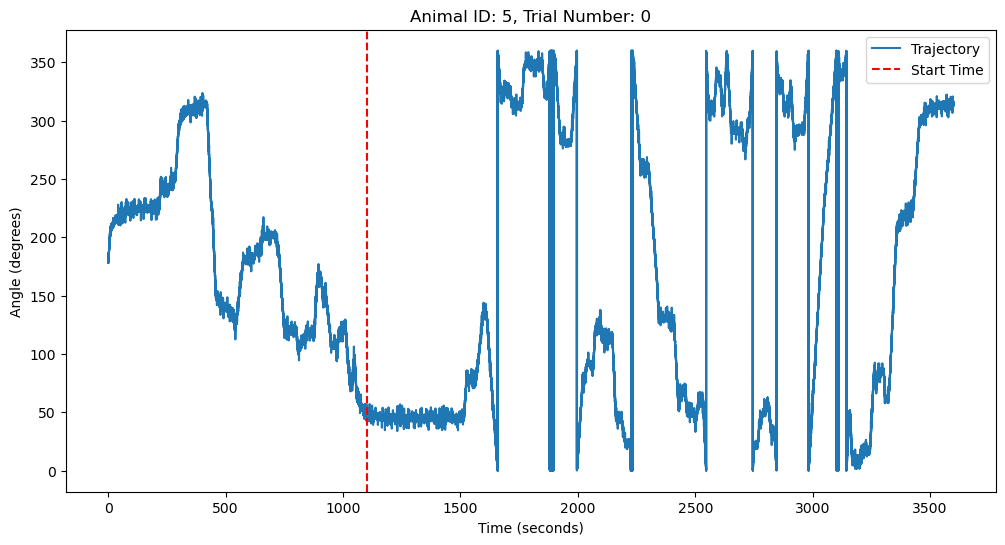

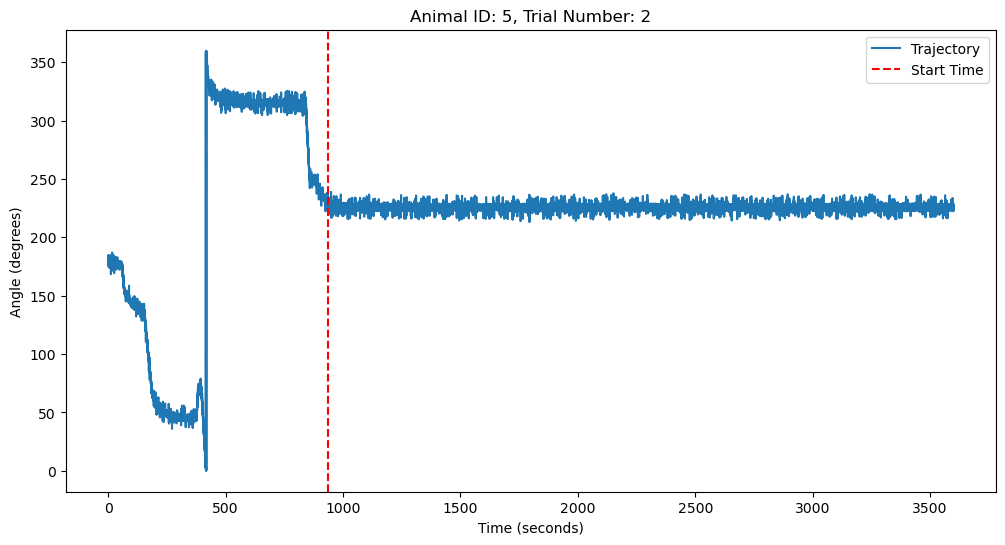

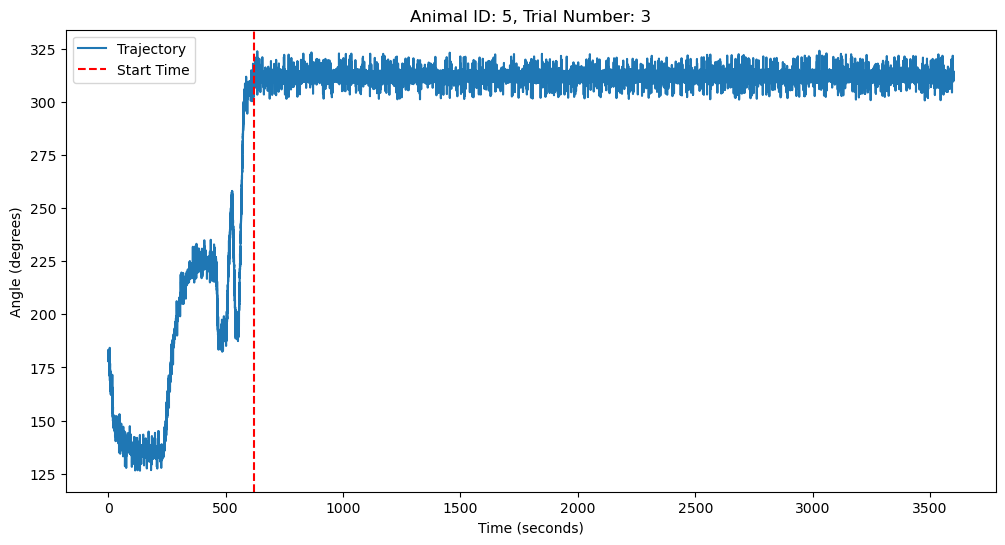

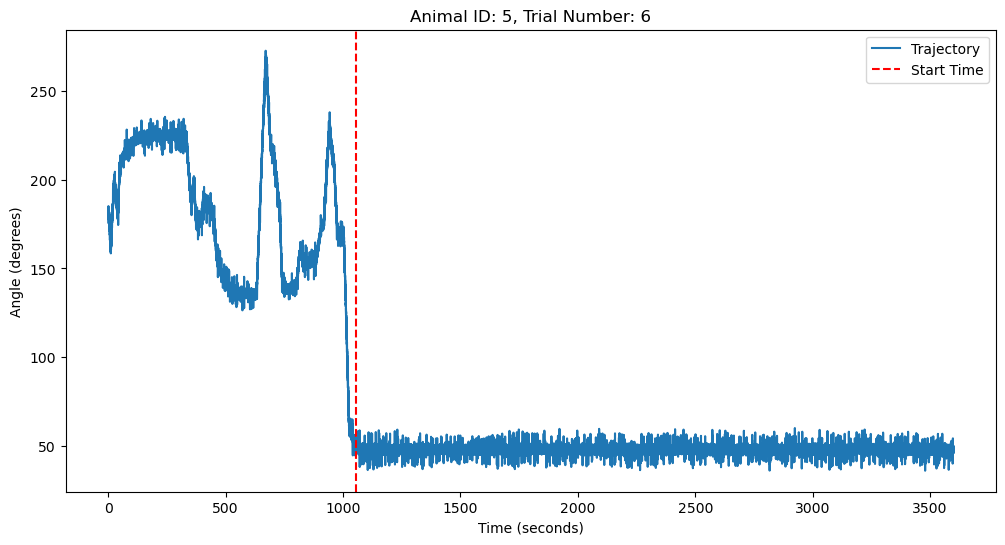

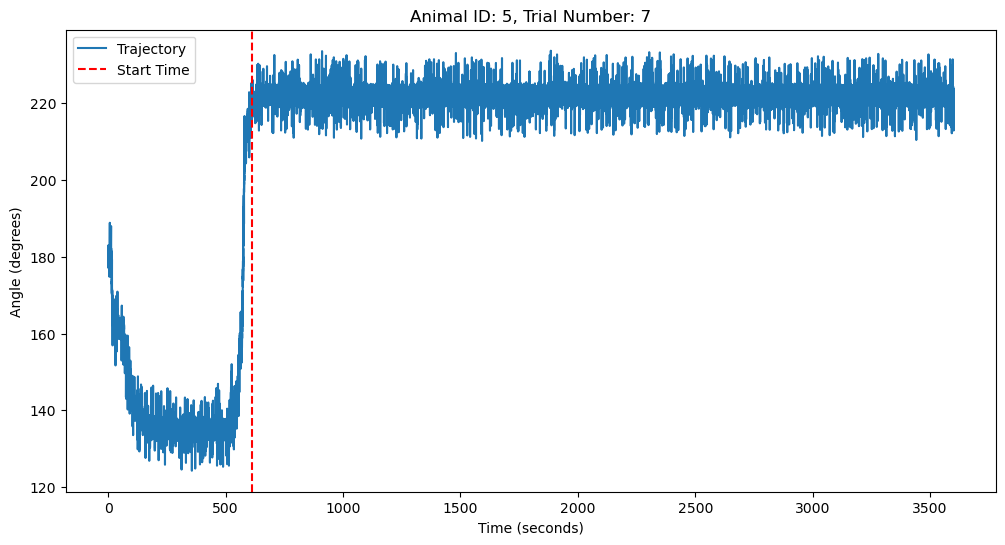

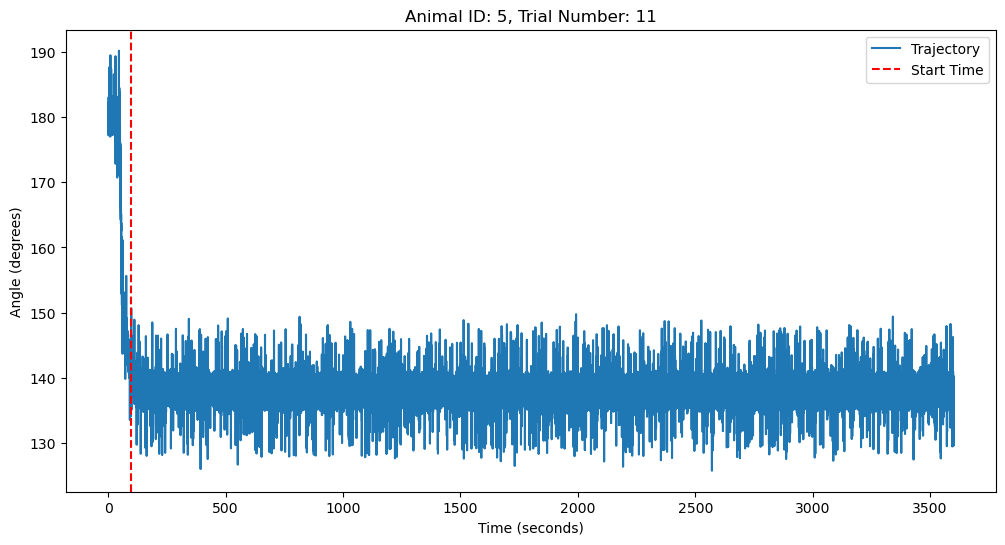

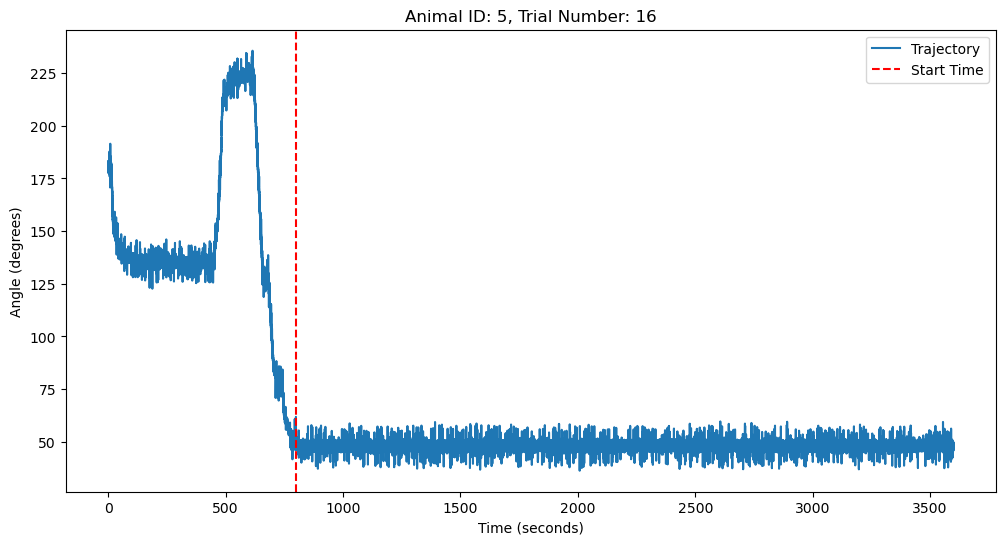

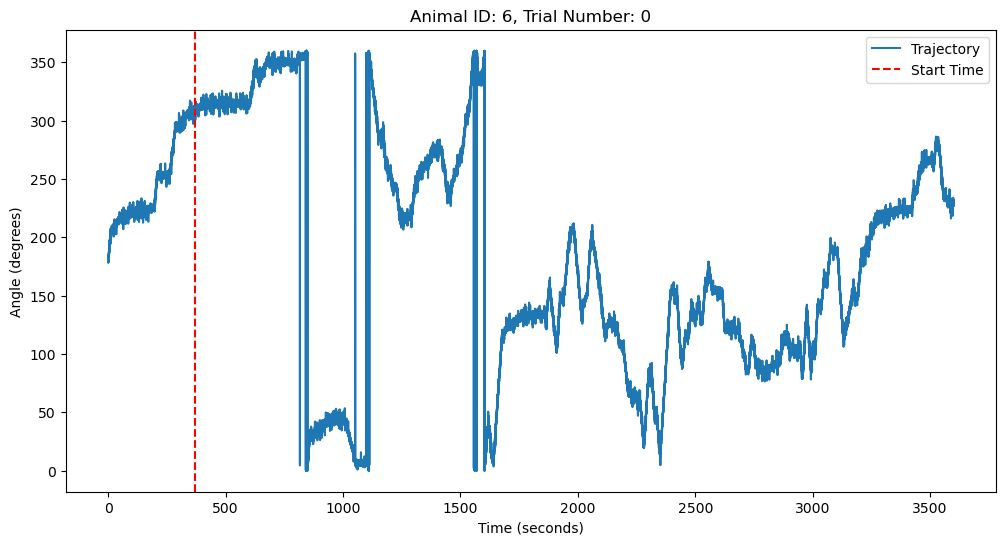

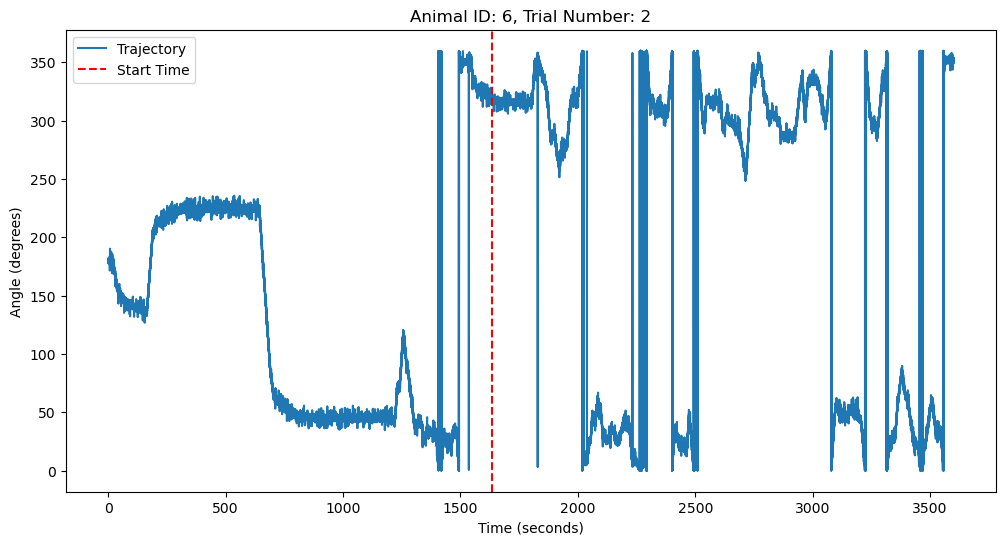

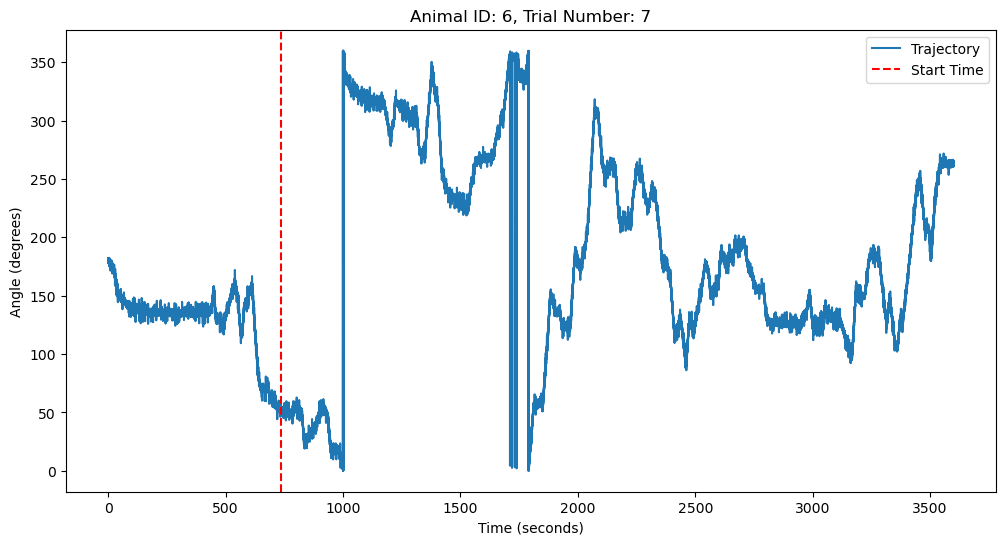

KeyboardInterrupt: 

In [7]:
import os
import json
import matplotlib.pyplot as plt

# Define the filepaths
input_folder = "/media/alexmatthews/Alex_011/ZOOL412/rot_learning_cutdown"
output_folder = "/media/alexmatthews/Alex_011/ZOOL412/rot_learning_outputs"
output_file = os.path.join(output_folder, "rotational_data_processed.json")

# Load the processed data from the JSON file
with open(output_file, 'r') as json_file:
    processed_data = json.load(json_file)

# Function to plot the trajectory data with the start time marked
def plot_trajectory(filepath, data):
    with open(filepath, 'r') as file:
        lines = file.readlines()
    
    # Clean lines from newline characters and empty lines
    lines = [line.strip() for line in lines if line.strip()]
    
    # Extract trajectory data
    trajectory_data_start = lines.index("Trajectory Data (Time, Angle)") + 1
    trajectory_data = []
    for line in lines[trajectory_data_start:]:
        if line.strip() and not line.startswith("----"):  # Skip empty lines and lines with dashes
            try:
                time, angle = map(float, line.split())
                trajectory_data.append((time, angle))
            except ValueError:
                continue
    
    # Plot the trajectory data
    times = [point[0] for point in trajectory_data]
    angles = [point[1] for point in trajectory_data]
    
    plt.figure(figsize=(12, 6))
    plt.plot(times, angles, label='Trajectory')
    
    # Mark the start time
    start_time = data['start_time']
    if start_time is not None:
        plt.axvline(x=start_time, color='r', linestyle='--', label='Start Time')
    
    plt.xlabel('Time (seconds)')
    plt.ylabel('Angle (degrees)')
    plt.title(f"Animal ID: {data['animal_id']}, Trial Number: {data['trial_number']}")
    plt.legend()
    plt.show()

# Iterate over the processed data and plot for each trial
for animal_id, trials in processed_data.items():
    for trial_number, data in trials.items():
        filename = f"rot_learn_{data['learning_odour']}_animal_{int(animal_id):02d}_trial_{int(trial_number):02d}.txt"
        filepath = os.path.join(input_folder, filename)
        plot_trajectory(filepath, data)
